# Speaker Recognition

This CDS project uses VCTK dataset which is conveinet to collect from tensorflow built-in packages and the objective of this model aims to correctly predict the speaker given audio files with various accents after training.

Note that the dataset is downloaded and collected from:

https://metatext.io/datasets/cstr-vctk-corpus


Section 1: Data Preprocessing and saved them to be CSV files and Pandas AND Data Preparation to extarct main features. 

Section 2: Data Split for training, testing, and validation set AND Data handling.

Section 3: Model Training

Section 4: Evalution Methodology

Section 5: Results Discussion

#### (Please refer to the report for more detailed information on each section)


### Import Necessary Libraries

In [1]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import numpy
import csv
import os
# import librosa
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import time

from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
# from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
import keras

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Convolution2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import l2
import collections

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Using TensorFlow backend.


### Section 1: Data Pre-processing and Feature Extraction

In [66]:
CREATE_CSV_FILES = True

os.mkdir("fold")
def extractWavFeatures(soundFilesFolder, csvFileName,n):
    header = 'speaker_ID audio_no chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    a = 0
    for t in os.listdir(f'{soundFilesFolder}'):
        for audiofile in os.listdir(f'{soundFilesFolder}/{t}'):
            number = f'{soundFilesFolder}/{t}/{audiofile}'
            try:
                os.popen(r"ffmpeg -i " + number + " fold/lol" + str(a) + ".wav")
                time.sleep(1)
                y, sr = librosa.load("fold/lol" + str(a) + ".wav", mono=True, duration=30)
                # remove leading and trailing silence
                y, index = librosa.effects.trim(y)
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rmse = librosa.feature.rms(y=y)
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(y)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                to_append = f'{n} {number[-9:-4]} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
                for e in mfcc:
                    to_append += f' {np.mean(e)}'
                writer.writerow(to_append.split())
            except:
                pass
            a+=1
    for i in os.listdir('fold'):
        os.remove('fold/' + i)
    file.close()

start = 256
if (CREATE_CSV_FILES == True):
    n = start
    for filename in os.listdir('aac')[start:start+50]:
        extractWavFeatures("aac/"+filename, "processed_data/data_" + filename + ".csv",n)
        n+=1
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

In [ ]:
if (CREATE_CSV_FILES == True):
    ls_speaker = []
    ls_no = []
    n = 0
    for filename in os.listdir('wav48'):
        ls_speaker.append(filename)
        ls_no.append(n)
        n+=1
    df = pd.DataFrame({'speaker' : ls_speaker, 'speaker_ID' : ls_no})
    df.to_csv("speaker_id.csv")

In [9]:
ls = []
for filename in os.listdir('processed_data')[1:]:
    if filename[-4:] == '.csv':
        df = pd.read_csv('processed_data/' + filename, index_col=None)
        df['speaker_ID'] = filename[-9:-4]
        ls.append(df)
data = pd.concat(ls, axis=0, ignore_index=True)
data.to_csv("processed_data.csv")
data

305


,speaker_ID,audio_no,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,00015,1,0.379848,0.058641,2183.993438,1966.914912,4365.645824,0.122533,-227.997345,118.860397,...,-1.374323,-9.581794,9.021810,-15.108976,5.588908,-12.163164,-0.766514,-8.645349,0.070057,-6.424212
1,00015,2,0.399544,0.054323,2471.372694,2073.702482,4909.724488,0.145312,-249.837112,98.665833,...,0.613816,-9.123156,6.266958,-17.668642,6.246927,-12.596469,-2.481917,-8.638479,0.052736,-8.328897
2,00015,3,0.406731,0.082201,1755.869882,1719.163452,3384.039797,0.102034,-239.030167,117.625549,...,-2.193602,-9.892931,3.132732,-10.518177,-3.378300,-4.758576,-2.816393,-8.925706,-0.373998,-6.242197
3,00015,4,0.389571,0.097917,2032.380102,1803.530584,3899.274041,0.125055,-211.685898,113.538261,...,-3.831773,-8.707665,4.339125,-14.763656,0.442886,-9.768138,-1.140195,-10.973631,0.294681,-7.219910
4,00015,5,0.334093,0.140168,1328.306169,1445.535463,2543.972679,0.070680,-210.197205,145.377350,...,-3.746988,-7.422366,2.745238,-13.812215,-5.410058,-4.361364,-3.463450,-11.304767,-1.998235,-6.305733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53661,00476,195,0.449314,0.065663,1595.627610,1684.452566,3237.284128,0.083336,-215.914886,145.068970,...,3.412253,-6.149935,6.776699,-10.553801,3.643635,-6.765225,2.021735,-9.681848,-0.488664,-1.942586
53662,00476,127,0.386262,0.037206,942.753808,1121.121834,1777.559622,0.047352,-322.181366,183.218079,...,3.233587,-1.808537,7.785980,-1.594686,2.217745,-1.808597,2.315601,-7.009542,-6.316716,3.170432
53663,00476,128,0.319189,0.150587,1214.942086,1239.098921,2242.589851,0.070607,-180.102402,170.932449,...,5.126051,-5.535160,6.152314,-10.391240,6.696593,-1.755336,-7.653257,-1.255253,-1.411345,2.326839
53664,00476,196,0.349616,0.104618,1305.339073,1238.617494,2456.151068,0.068644,-226.289322,159.334396,...,-1.709631,-5.385680,4.777824,-5.783535,-2.787717,-3.041267,-1.809801,-4.355329,-6.848184,-1.070593


In [39]:
ls = []
for filename in os.listdir('new_data'):
    df = pd.read_csv('new_data/' + filename, index_col=None)
    ls.append(df)
data = pd.concat(ls, axis=0, ignore_index=True)
data.to_csv("processed_data_new.csv")

In [17]:
df = pd.read_csv("combined/processed_data_new.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
dc = {}
n = 109
for i in range(len(df)):
    if dc.get(df['speaker_ID'][i],False):
        df['speaker_ID'][i] = dc[df['speaker_ID'][i]]
    else:
        dc[df['speaker_ID'][i]] = n
        n+=1
        df['speaker_ID'][i] = dc[df['speaker_ID'][i]]
df.head()

,speaker_ID,audio_no,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,109,1,0.379848,0.058641,2183.993438,1966.914912,4365.645824,0.122533,-227.997345,118.860397,...,-1.374323,-9.581794,9.021810,-15.108976,5.588908,-12.163164,-0.766514,-8.645349,0.070057,-6.424212
1,109,2,0.399544,0.054323,2471.372694,2073.702482,4909.724488,0.145312,-249.837112,98.665833,...,0.613816,-9.123156,6.266958,-17.668642,6.246927,-12.596469,-2.481917,-8.638479,0.052736,-8.328897
2,109,3,0.406731,0.082201,1755.869882,1719.163452,3384.039797,0.102034,-239.030167,117.625549,...,-2.193602,-9.892931,3.132732,-10.518177,-3.378300,-4.758576,-2.816393,-8.925706,-0.373998,-6.242197
3,109,4,0.389571,0.097917,2032.380102,1803.530584,3899.274041,0.125055,-211.685898,113.538261,...,-3.831773,-8.707665,4.339125,-14.763656,0.442886,-9.768138,-1.140195,-10.973631,0.294681,-7.219910
4,109,5,0.334093,0.140168,1328.306169,1445.535463,2543.972679,0.070680,-210.197205,145.377350,...,-3.746988,-7.422366,2.745238,-13.812215,-5.410058,-4.361364,-3.463450,-11.304767,-1.998235,-6.305733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169235,1070,310,0.397159,0.067154,1342.551956,1506.739897,2744.322294,0.058491,-256.082977,148.155228,...,6.744627,-5.229660,4.547461,-7.986094,10.509853,-5.043070,-6.217235,1.719076,1.688926,-10.032303
169236,1070,309,0.393787,0.093265,1251.885180,1404.378063,2434.612568,0.058076,-285.258179,144.609253,...,3.494340,-6.001729,1.387389,-7.814054,7.266153,-2.935897,-4.731778,-4.666720,3.732070,-5.447401
169237,1070,313,0.455731,0.079907,1124.647477,1368.126446,2197.016345,0.049271,-248.111221,150.958084,...,13.482922,-3.055493,5.607987,-1.921256,3.984825,0.953070,-6.092802,1.536644,-0.215987,-9.403486
169238,1070,314,0.425446,0.047386,1456.718549,1561.903315,2833.199535,0.071289,-299.353607,141.348373,...,5.715798,-8.343728,5.452426,-4.369521,10.065316,-3.754707,-2.699076,-0.510726,2.078652,-9.018994


In [33]:
pd.DataFrame(dc.items(), columns=['voxceleb_id', 'new_id']).to_csv("VoxCeleb_speaker_mapping.csv")

In [28]:
df2 = pd.read_csv("combined/processed_data_old.csv")
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
final_df = pd.concat([df2, df])
print("Number of datapoints after combining all the datasets : " + str(len(final_df)))

Number of datapoints after combining all the datasets : 213482


In [34]:
final_df.to_csv("final_processed_data.csv")

### Section 2:  (1) Data Split:
##### training 70%, testing 15%, validation 15%

In [2]:
data = pd.read_csv("final_processed_data.csv")
# Remove Unnamed columns in pandas dataframe 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.drop(['chroma_stft'], axis=1) # We are not including this in the features as 
data.head()

,speaker_ID,audio_no,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0,1,0.074879,2497.929082,2268.324461,4347.529516,0.143012,-307.451050,57.879471,11.893770,...,-7.967688,4.199481,1.773855,8.009322,6.938719,7.036314,3.976959,5.085256,-1.438815,-1.099089
1,0,2,0.066099,1892.849522,2102.600575,3327.249023,0.101247,-329.564026,66.828552,12.338695,...,-6.671147,7.486201,0.502710,9.984730,9.007502,5.632601,3.501462,0.573889,0.040695,-1.841341
2,0,3,0.082535,2222.535114,2077.810702,3791.664807,0.125326,-285.457520,66.315643,4.616204,...,-9.837260,4.760407,1.058571,9.786856,7.887321,4.413044,3.874553,-0.641774,-0.236349,-2.570449
3,0,4,0.038500,2329.075694,2209.758315,4238.641036,0.129230,-358.046478,77.588943,9.536255,...,-12.063831,3.719922,-0.350510,8.737763,7.851452,6.955077,1.107642,0.476409,1.042075,-3.172532
4,0,5,0.059668,2049.902594,2058.925424,3684.239424,0.102652,-319.828186,77.458374,1.410514,...,-11.323690,5.027639,-0.350707,9.504244,7.045327,3.448477,0.928960,-1.604680,-0.050544,-3.968508


In [3]:
# speaker_data = pd.read_csv("speaker_id.csv")
# speaker_data = speaker_data.loc[:, ~speaker_data.columns.str.contains('^Unnamed')]
# speaker_data.tail()

,speaker,speaker_ID
105,p314,105
106,p313,106
107,p376,107
108,p347,108
109,p340,109


In [17]:
# split to : training 70%, testing 15%, validation 15%

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.3, stratify = data['speaker_ID'], random_state = 42)
test, val = train_test_split(test, test_size = 0.5, stratify = test['speaker_ID'], random_state = 42)
train.to_csv("train.csv")
val.to_csv("val.csv")
test.to_csv("test.csv")

#### To read the data

In [69]:
#alternatively: read given csv files directly
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
val = val.loc[:, ~val.columns.str.contains('^Unnamed')]

In [68]:
data = pd.read_csv("final_processed_data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

### Section 2: (2) Data Exploration and Visualization

To understand another approach which can be utilised in our final presentation, we can convert the .wav audio files to melspectogram which gives us data related to how each frequency is understood by humans with the help of mel scale (explained in the report). We are not extracting this feature in our current approach

The next two graphs which are histogram and boxplot helps us understand the distribution of number of audio files for speakers in the dataset. We can see there is an imbalance in the number of data for different speakers as most speakers have 400 audio files but there are some outliers which are either under represented or over represented. 

This helps us understand the correction between our target variable which is speaker_ID and the features. This can be used to remove features which may not have correlation with our target variable, helping us reduce the computational cost of training/prediction and in some cases, improve the performance of the model.

The correlation matrix below helps us understand the correlation between different features and our target variable in the data.

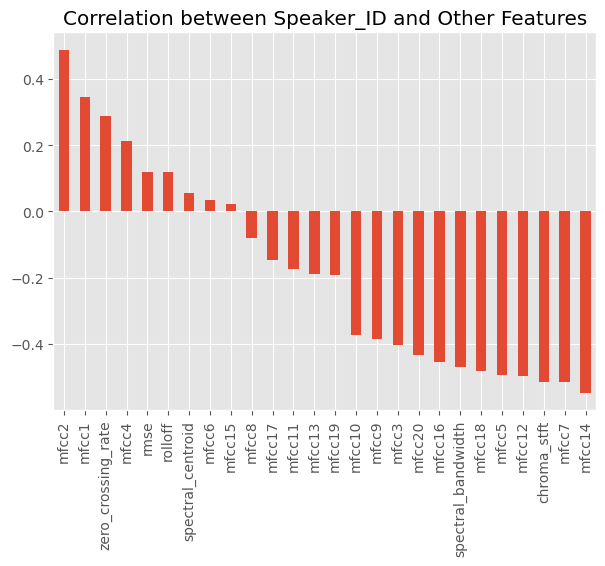

In [39]:
corr_matrix = data.corr()
df = corr_matrix["speaker_ID"].sort_values(ascending=False)
df.pop('speaker_ID')
df.pop('audio_no')
plt.style.use('ggplot')
plt.title("Correlation between Speaker_ID and Other Features")
ax = df.plot.bar()

### Section 2: (3) Data Handling e.g. Normalization

In [70]:
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

def preProcessData(data):
    
    print("being preprocessed")
    
    #Dropping unnecessary columns as it has no effect in the final result
    
    label = data[['speaker_ID']]
    data = data.drop(['speaker_ID'], axis=1)
    data = data.drop(['audio_no'], axis=1)
    # We removed these features as it improved the performance of our model.
    data = data.drop(['spectral_centroid'], axis=1) 
    data = data.drop(['rmse'], axis=1) 
    data = data.drop(['rolloff'], axis=1) 



    print("Preprocessing is finished")
    
    return data, label

X_train, y_train = preProcessData(train)
X_val, y_val = preProcessData(val)
X_test, y_test = preProcessData(test)


being preprocessed
Preprocessing is finished
being preprocessed
Preprocessing is finished
being preprocessed
Preprocessing is finished


In [71]:
# Start normalizing data
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True))

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [72]:
# validate if irrelevant columns have be removed

# print("X_train:\n", X_train.head())
# print("X_val:\n", X_val.head())
# print("X_test:\n", X_test.head())

In [73]:
# validate if the data has been normalized 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(149437, 23)
(149437, 1)
(32022, 23)
(32022, 1)
(32023, 23)
(32023, 1)


### SMOTE sampling after preparation

In [8]:
# sample = SMOTE(random_state = 42)
# X_train_sample, y_train_sample = sample.fit_resample(X_train, y_train)

In [5]:
# sample = SMOTEENN(random_state = 42)
# X_train_sample, y_train_sample = sample.fit_resample(X_train, y_train)

In [21]:
# sample = SMOTETomek(random_state = 42)
# X_train_sample, y_train_sample = sample.fit_resample(X_train, y_train)

In [10]:
# sample = ADASYN(random_state = 42, sampling_strategy='minority')
# X_train_sample, y_train_sample = sample.fit_resample(X_train, y_train)

### OverSampling after preparation

In [53]:
# ros = RandomOverSampler()
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
# X_test_ros, y_test_ros = ros.fit_resample(X_test, y_test)
# X_val_ros, y_val_ros = ros.fit_resample(X_val, y_val)

## UnderSampling after preparation

In [9]:
# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
# X_test_rus, y_test_rus = rus.fit_resample(X_test, y_test)
# X_val_rus, y_val_rus = rus.fit_resample(X_val, y_val)

In [10]:
# print(X_train_ros.shape)
# print(y_train_ros.shape)
# print(X_test_ros.shape)
# print(y_test_ros.shape)
# print(X_val_ros.shape)
# print(y_val_ros.shape)

# print(X_train_rus.shape)
# print(y_train_rus.shape)
# print(X_test_rus.shape)
# print(y_test_rus.shape)
# print(X_val_rus.shape)
# print(y_val_rus.shape)

### Combination of both oversampling and undersampling

In [8]:
# over = RandomOverSampler(sampling_strategy = 0.5)
# under = RandomUnderSampler(sampling_strategy = 0.5)
# X_train_over, y_train_over = over.fit_resample(X_train, y_train)
# X_test_over, y_test_over = over.fit_resample(X_test, y_test)
# X_val_over, y_val_over = over.fit_resample(X_val, y_val)

# X_combined_train, y_combined_train = under.fit_resample(X_train_over, y_train_over)
# X_combined_test, y_combined_test = under.fit_resample(X_test_over, y_test_over)
# X_combined_val, y_combined_val = under.fit_resample(X_val_over, y_val_over)

#error message:ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.


In [11]:
# print(X_combined_train.shape)
# print(y_combined_train.shape)
# print(X_combined_test.shape)
# print(y_combined_test.shape)
# print(X_combined_val.shape)
# print(y_combined_val.shape)

### Section 3: Model Training

In [103]:
model = models.Sequential()

# model.add(layers.Dense(8192, activation='selu', input_shape=(X_train.shape[1],)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(4096, activation='selu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(4096, activation='selu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(2048, activation='selu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1071, activation='softmax'))

model.add(layers.Dense(8192, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1071, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# simple early stopping


es = EarlyStopping(monitor='val_loss', mode='min', patience = 10, verbose=1)

#Train with early stopping to avoid overfitting

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

# history = model.fit(X_train_ros,
#                     y_train_ros,
#                     validation_data=(X_val_ros, y_val_ros),
#                     epochs=50,
#                     batch_size=128, 
#                     callbacks=[es])

# history = model.fit(X_train_rus,
#                     y_train_rus,
#                     validation_data=(X_val_rus, y_val_rus),
#                     epochs=50,
#                     batch_size=128, 
#                     callbacks=[es])

Epoch 1/50
1168/1168 [==============================] - 18s 15ms/step - loss: 3.2313 - accuracy: 0.3516 - val_loss: 1.6916 - val_accuracy: 0.6193
Epoch 2/50
1168/1168 [==============================] - 18s 15ms/step - loss: 2.0104 - accuracy: 0.5362 - val_loss: 1.2628 - val_accuracy: 0.7143
Epoch 3/50
1168/1168 [==============================] - 18s 15ms/step - loss: 1.7076 - accuracy: 0.5934 - val_loss: 1.0706 - val_accuracy: 0.7536
Epoch 4/50
1168/1168 [==============================] - 18s 15ms/step - loss: 1.5532 - accuracy: 0.6243 - val_loss: 0.9690 - val_accuracy: 0.7763
Epoch 5/50
1168/1168 [==============================] - 18s 15ms/step - loss: 1.4490 - accuracy: 0.6459 - val_loss: 0.9103 - val_accuracy: 0.7889
Epoch 6/50
1168/1168 [==============================] - 18s 15ms/step - loss: 1.3824 - accuracy: 0.6614 - val_loss: 0.8358 - val_accuracy: 0.8020
Epoch 7/50
1168/1168 [==============================] - 18s 15ms/step - loss: 1.3339 - accuracy: 0.6723 - val_loss: 0.8182 -

In [97]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 8192)              196608    
_________________________________________________________________
dropout_21 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 4096)              33558528  
_________________________________________________________________
dropout_22 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1071)             

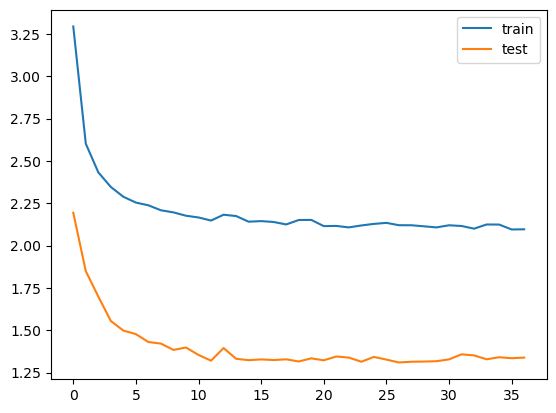

In [98]:
plt.style.use('default')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Section 4: Model Evaluation:

In [33]:
def printPrediction(X_data, y_data, printDigit):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = str(model.predict_classes(X_data[i:i+1])[0])
        speaker = str(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [89]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    Y_prob = model.predict_proba(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))
    auc = roc_auc_score(y_data, Y_prob, multi_class = 'ovr')
    print('AUC score: %.10f' % auc)



In [49]:
print('\n# TEST DATA #\n')

score = model.evaluate(X_test, y_test)

# score = model.evaluate(X_test_ros, y_test_ros)

# score = model.evaluate(X_test_rus, y_test_rus)

print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
y_temp = list(y_test['speaker_ID'])#.reset_index()
printPrediction(X_test[0:10], y_temp[0:10], False)


# TEST DATA #

1001/1001 [==============================] - 2s 2ms/step - loss: 0.6797 - accuracy: 0.8548
accuracy: 85.48%

# Generate predictions
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
y=843       - prediction=800       - match=False
y=642       - prediction=642       - match=True
y=634       - prediction=634       - match=True
y=644       - prediction=664       - match=False
y=718       - prediction=718       - match=True
y=1067      - prediction=1067      - match=True
y=111       - prediction=111       - match=True
y=496       - prediction=496       - match=True
y=712       - prediction=694       - match=False
y=701       - prediction=701       - match=True


Classification Report for Test Data

[[34  0  0 ...  0  0  0]
 [ 0 52  1 ...  0  0  0]
 [ 0  0 57 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  0 ...  0 70  0]
 [ 0  0  0 ...  0  0 72]]


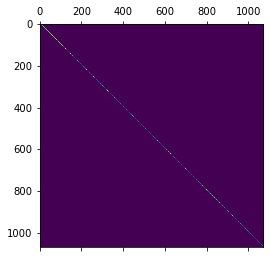


Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       0.98      0.98      0.98        53
           2       0.98      0.98      0.98        58
           3       0.91      0.96      0.94        55
           4       0.92      0.98      0.95        57
           5       1.00      0.93      0.96        59
           6       0.97      0.97      0.97        68
           7       0.98      0.98      0.98        62
           8       0.90      1.00      0.95        56
           9       0.96      0.98      0.97        53
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        51
          12       0.97      1.00      0.99        68
          13       0.94      1.00      0.97        75
          14       0.85      0.93      0.89        56
          15       0.98      1.00      0.99        53
          16       1.00      1.00      1.00        59
    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC score: 0.9984410880


In [90]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

#### No class test - to make sure our model is able to learn about the speakers in the dataset, we introduced 100 speakers outside of the dataset to test the robustness of the model

In [64]:
test_noclass = pd.read_csv("test_noclass.csv")
test_noclass = test_noclass.loc[:, ~test_noclass.columns.str.contains('^Unnamed')]
test_noclass = test_noclass.drop("chroma_stft", axis = 1)

X_noclass_test, y_noclass_test = preProcessData(test_noclass)
X_noclass_test = scaler.transform(X_noclass_test)

being preprocessed
Preprocessing is finished


In [101]:
Y_prob = model.predict_proba(X_noclass_test)
n = 0
for i in Y_prob:
    if max(i)<0.5:
        n+=1
print("Percentage of noclass datapoints with < 0.5 probability for all the clases : " + str(n/len(X_noclass_test)))

Percentage of noclass datapoints with < 0.5 probability for all the clases : 0.7393348623853211


#### Comparing the f1-score performance for VCTK and VoxCeleb2 dataset

In [75]:
y_pred = model.predict_classes(X_test)
ls = f1_score(y_test, y_pred, average=None)
print("Average F1-score of VCTK dataset : " + str(sum(ls[:109])/len(ls[:109])))
print("Average F1-score of portion of VoxCeleb2 dataset : " + str(sum(ls[109:])/len(ls[109:])))

Average F1-score of VCTK dataset : 0.9613703785556486
Average F1-score of portion of VoxCeleb2 dataset : 0.7594284195233783


### Section 5: Results Discusion: Please check the report

### Rough work

In [ ]:
#no class test
Y_prob = model.predict_proba(X_test)
n = 0
for i in Y_prob:
    if max(i)<0.5:
        n+=1
print("Percentage of test datapoints with < 0.5 probability for all the clases : " + str(n/len(X_test)))